In [2]:
%cd /content/drive/MyDrive/Miller et al, Adversarial Learning and Secure AI - Code (Chapter 04)

/content/drive/MyDrive/Miller et al, Adversarial Learning and Secure AI - Code (Chapter 04)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
import random
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from CNN.resnet import ResNet18
from load_data import load_data
#import torch.backends.cudnn as cudnn



# load the mnist dataset (images are resized into 32 * 32)
training_set, test_set = load_data(data='mnist')

# define the model
model = ResNet18()

# detect if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"


# load the learned model parameters
model.load_state_dict(torch.load('/content/drive/MyDrive/Miller et al, Adversarial Learning and Secure AI - Code (Chapter 04)/cpu_model.pth'))

model.to(device)
model.eval()

# todo note below is an example of getting the Z(X) vector in the ZOO paper

'''
z = model(image)

# if we consider just one image with size (1, 1, 32, 32)
# z.size() :   (1, 10)  10 elements are corresponding to classes

'''

# def zoo_attack(network, image, t_0):

import torch
import torch.nn as nn
import torch.optim as optim

def zoo_attack(network, image, t_0, iters=200, epsilon=0.1, alpha=0.01, lr=0.05):
    """
    Perform a ZOO attack on a single image.

    Parameters:
    - model: The PyTorch model to attack.
    - image: Input image (torch.Tensor) to perturb.
    - t_0: True label of the image.
    - iters: Number of iterations to run the attack.
    - epsilon: Maximum perturbation allowed.
    - alpha: Step size for gradient approximation and update.
    - lr: Learning rate for optimizer.

    Returns:
    - perturbed_image: Adversarially perturbed image.
    """
    # Ensure model is in evaluation mode
    model.eval()

    # Move image and label to the correct device
    device = next(model.parameters()).device
    image = image.to(device)
    t_0 = t_0.to(device)

    # Clone the original image to create the perturbed image
    perturbed_image = image.clone().detach().requires_grad_(True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([perturbed_image], lr=lr)

    for i in range(iters):
        # Forward pass
        outputs = model(perturbed_image)
        loss = criterion(outputs, t_0)

        # Zero gradients, backward pass, and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Instead of using the true gradient (because we're simulating a black-box scenario),
        # we approximate the gradient direction using the sign of the gradient of the perturbed image
        grad_approx = perturbed_image.grad.sign()

        # Update the perturbed image using the gradient approximation
        perturbed_image = perturbed_image + alpha * grad_approx

        # Apply the perturbation constraints
        perturbed_image = torch.max(torch.min(perturbed_image, image + epsilon), image - epsilon)
        perturbed_image = torch.clamp(perturbed_image, 0, 1).detach().requires_grad_()

    return perturbed_image



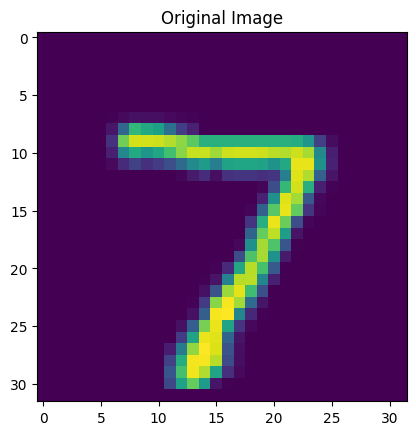

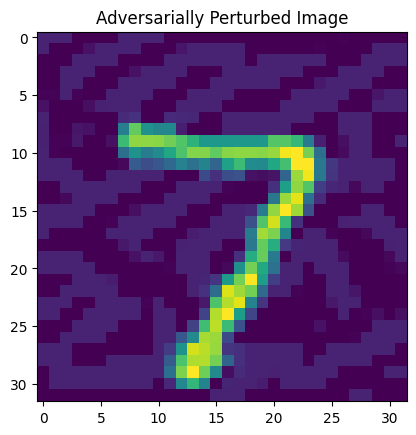

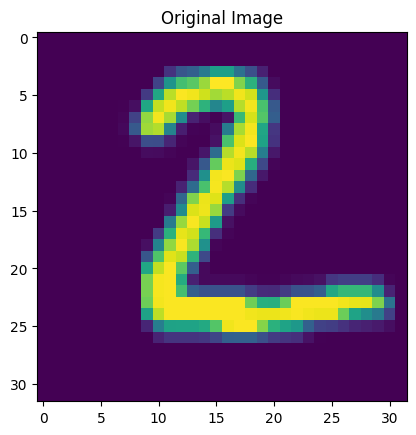

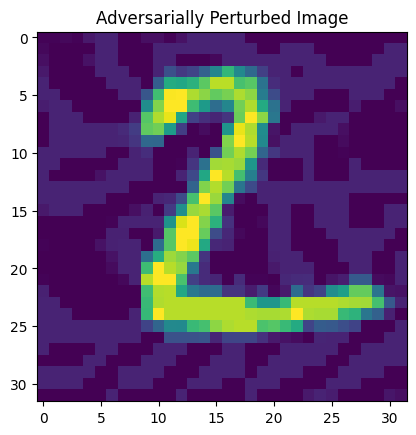

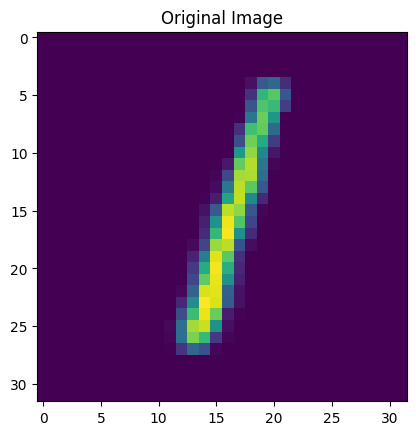

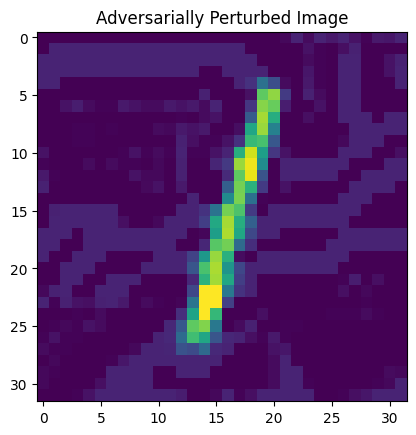

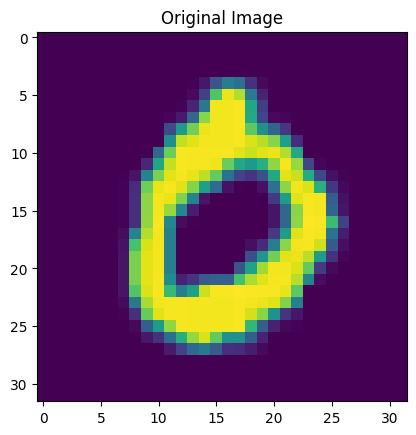

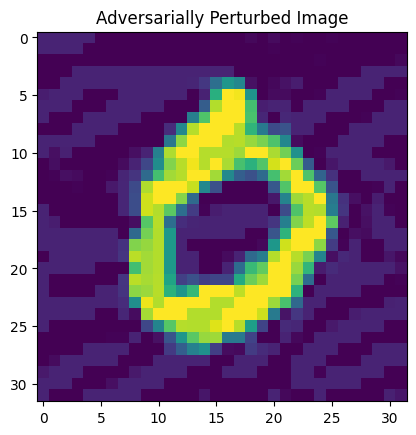

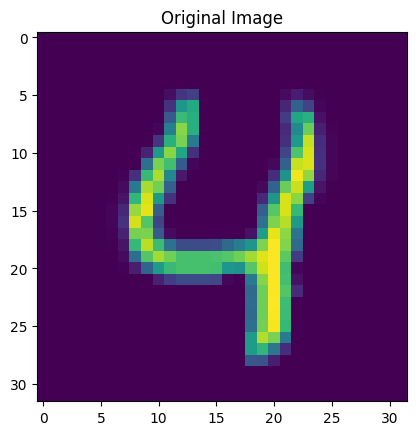

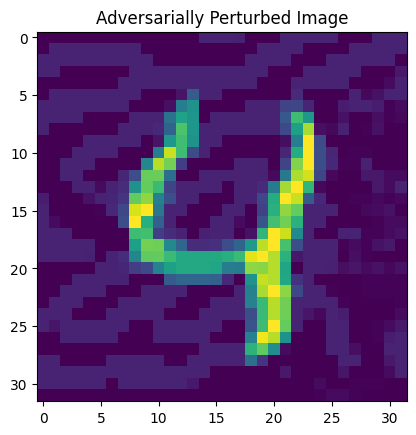

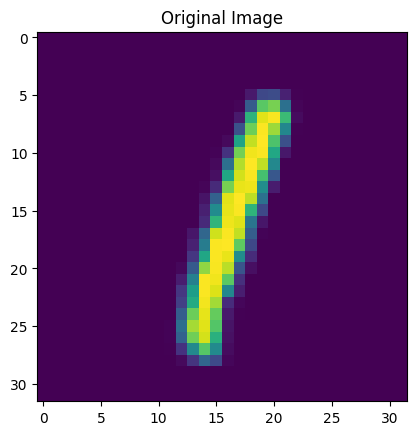

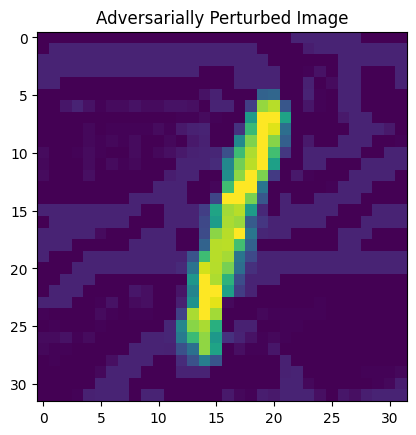

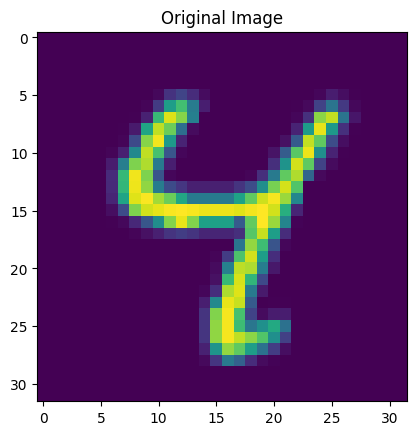

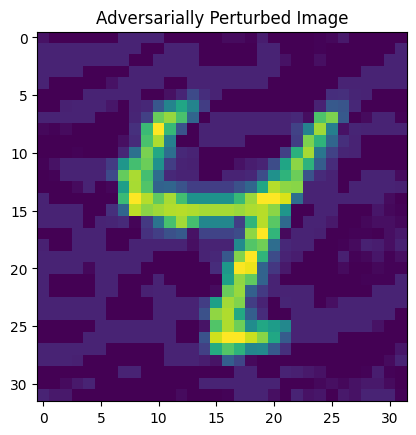

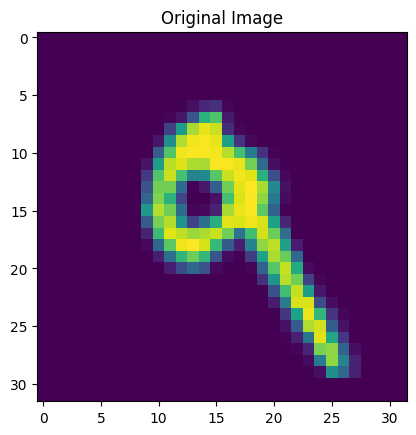

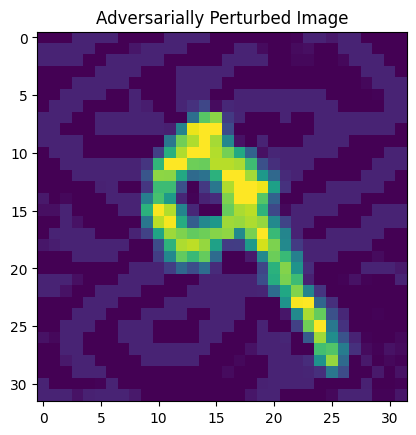

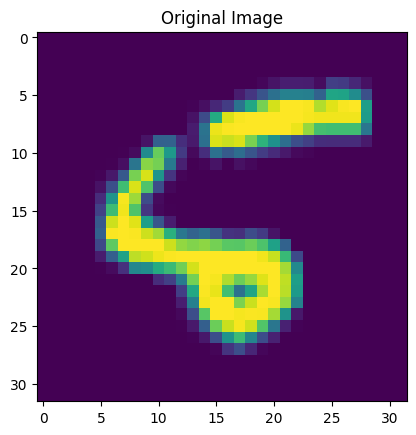

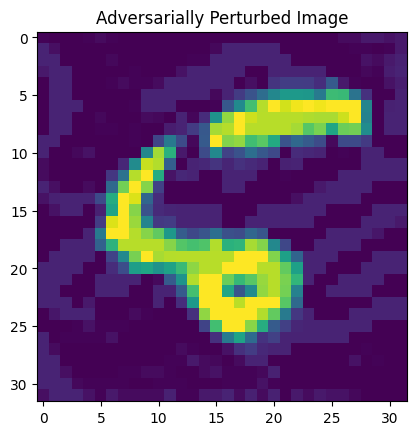

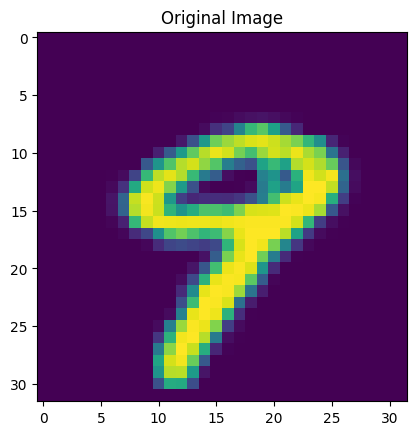

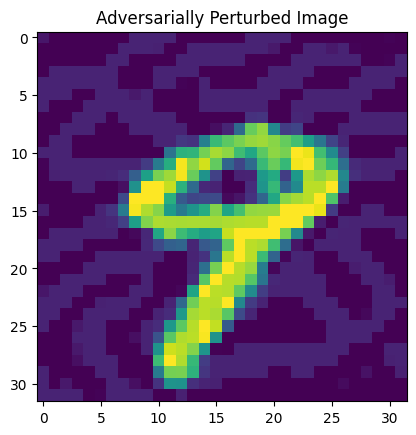

Success rate: 0.9000


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def imshow(img, title):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().cpu().numpy()  # Fix here
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

total = 0
success = 0
num_image = 10 # number of images to be attacked

for i, (images, labels) in enumerate(testloader):
    target_label = get_target(labels)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = outputs.max(1)
    if predicted.item() != labels.item():
        continue

    total += 1

    adv_image = zoo_attack(network=model, image=images, t_0=labels)
    adv_image = adv_image.to(device)
    adv_output = model(adv_image)
    _, adv_pred = adv_output.max(1)
    if adv_pred.item() != labels.item():
        success += 1

    # Visualize original and adversarially perturbed images
    imshow(images[0], title='Original Image')
    imshow(adv_image[0], title='Adversarially Perturbed Image')

    if total >= num_image:
        break

print('Success rate: %.4f' % (success / total))
